In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
import matplotlib.pyplot as plt
import healsparse as hsp
import skyproj
import seaborn as sns
import Config
from CropSurveyProperties import *
from GetObjects import *
from TrainAndFullMap import *

In [2]:
minGR = -0.3 # Minimum G-R color
maxGR = 1 # Maximum G-R color
res = 512 # Healpixel resolution
perCovered = 0.6 # Percent of healpixel that must have valid survey properties at the 4096 scale
sigma = 0.5 # Sigma used for gaussian weighting
perVar = 0.98 # Percent of the variance to be captured
perMap = 0.625 # Percent of the PC maps to use, adjust this later
numBins = 100 # Number of points in interpolation
magBins = [20, 22, 23, 24, 25, 26] # G magnitude bins

In [3]:
conditions = Config.conditions
likeDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/MaximumLikelihood/'
oldGalaDir = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/GalaxyContamination/'

In [4]:
deepFiles = ['/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000001.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000002.fits', 
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000003.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000004.fits',
             '/hdfs/bechtol/balrog/y3_deep_fields/y3_deep_fields_catalog/deepfields_000005.fits']

In [5]:
detBalrFile = '/hdfs/bechtol/balrog/y3/balrog_detection_catalog_sof_y3-merged_v1.2.fits'
matBalrFile = '/hdfs/bechtol/balrog/y3/balrog_matched_catalog_sof_y3-merged_v1.2.fits'
detBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
matBalrStarFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_matched_catalog_sof_run2_stars_v1.4.fits'

galaFile = likeDir + 'InjectionData/GalaxiesWithSize.fits'
starFile = likeDir + 'InjectionData/StarsWithSize.fits'

In [6]:
origCondFiles = Config.files[:-1]
stelFile = Config.files[-1]
pixFile = likeDir + 'PixAndConds/Valid_'+str(res)+'_Pixels.fits'
validPix = fitsio.read(pixFile)['PIXEL']
condFiles = []
for cond in conditions:
    condFiles.append(likeDir + 'PixAndConds/' + str(res) + '_' + cond + '.fits')
condFiles = np.array(condFiles)

In [7]:
def getStarsWithSize(minGR, maxGR, measStarFile, starFile, writeFile):
    '''
    This method is used to get and store the necessary balrog delta star information for later use.
    It applies basic quality cuts to the data and then stores it. Both files given need to be .fits files.
    This method only looks at stars that were detected so that a measured magnitude exists. 
    '''
    
    # This reads in all of the data. Most of these are just flags, but the g magnitude, ra, dec, detected
    # flag, and others will be stored for later use.
    measStarData = fitsio.read(measStarFile, columns = ['meas_ra', 'meas_dec', 'meas_EXTENDED_CLASS_SOF',
                                                'meas_psf_mag', 'bal_id', 'meas_cm_T'])
    
    starData = fitsio.read(starFile, columns = ['bal_id', 'flags_foreground', 'flags_badregions', 
                                                'flags_footprint', 'match_flag_1.5_asec'])
    

    RA = measStarData['meas_ra']
    DEC = measStarData['meas_dec']
    # PSF Magnitudes
    GMAG_PSF = measStarData['meas_psf_mag'][:,0]
    RMAG_PSF = measStarData['meas_psf_mag'][:,1]
    # This is the class that the object was measured as.
    CLASS = measStarData['meas_EXTENDED_CLASS_SOF']
    # This is the ID from the measured catalog.
    MEAS_ID  = measStarData['bal_id']
    SIZE = measStarData['meas_cm_T']
    
    sortInds = MEAS_ID.argsort()
    MEAS_ID = MEAS_ID[sortInds[::1]]
    RA = RA[sortInds[::1]]
    DEC = DEC[sortInds[::1]]
    GMAG_PSF = GMAG_PSF[sortInds[::1]]
    RMAG_PSF = RMAG_PSF[sortInds[::1]]
    CLASS = CLASS[sortInds[::1]]
    SIZE = SIZE[sortInds[::1]]
    
    # Everything from here on out is simply used in order to filter the data
    FOREGROUND = starData['flags_foreground']
    BADREGIONS = starData['flags_badregions']
    FOOTPRINT = starData['flags_footprint']
    ARCSECONDS = starData['match_flag_1.5_asec']
    FLAG_ID = starData['bal_id']
    
    sortInds = FLAG_ID.argsort()
    FLAG_ID = FLAG_ID[sortInds[::1]]
    FOREGROUND = FOREGROUND[sortInds[::1]]
    BADREGIONS = BADREGIONS[sortInds[::1]]
    FOOTPRINT = FOOTPRINT[sortInds[::1]]
    ARCSECONDS = ARCSECONDS[sortInds[::1]]
    
    # This will serve to align the flags with their measured counterpart.
    parallelInd = 0
    cropInds = []
    for i in np.arange(len(FLAG_ID)):
        if parallelInd >= len(MEAS_ID):
            break
        if MEAS_ID[parallelInd] == FLAG_ID[i]:
            cropInds.append(i)
            parallelInd += 1
            
    FOREGROUND = FOREGROUND[cropInds]
    BADREGIONS = BADREGIONS[cropInds]
    FOOTPRINT = FOOTPRINT[cropInds]
    ARCSECONDS = ARCSECONDS[cropInds]

    # This is used to filter out any injections that had flags raised.
    cutIndices = np.where((FOREGROUND == 0) & 
                          (BADREGIONS < 2) & 
                          (FOOTPRINT == 1) & 
                          (ARCSECONDS < 2) &
                          (CLASS >= 0) &
                          # Color cuts
                          (GMAG_PSF - RMAG_PSF >= minGR) &
                          (GMAG_PSF - RMAG_PSF <= maxGR))[0]

    # This reduced the data down to the actually valid pixels.
    RA = RA[cutIndices]
    DEC = DEC[cutIndices]
    GMAG_PSF = GMAG_PSF[cutIndices]
    RMAG_PSF = RMAG_PSF[cutIndices]
    CLASS = CLASS[cutIndices]
    SIZE = SIZE[cutIndices]
    
    useInds = np.where((GMAG_PSF < 37) & 
                       (RMAG_PSF < 37) &
                       (GMAG_PSF <= 25) &
                       (GMAG_PSF > 24))[0]

    RA = RA[useInds]
    DEC = DEC[useInds]
    GMAG_PSF = GMAG_PSF[useInds]
    RMAG_PSF = RMAG_PSF[useInds]
    CLASS = CLASS[useInds]
    SIZE = SIZE[useInds]
    
    my_table = Table()
    my_table['RA'] = RA
    my_table['DEC'] = DEC
    my_table['SIZE'] = SIZE
    my_table['CLASS'] = CLASS
    my_table.write(writeFile, overwrite = True)

In [8]:
# getStarsWithSize(minGR, maxGR, matBalrStarFile, detBalrStarFile, starFile)

In [9]:
def getGalas(minGR, maxGR, deepFiles, measBalrFile, balrFile, writeFile):
    '''
    This method serves to get and store the necessary balrog galaxy data for further use. It checks
    which balrog objects were originally deep field galaxies according to the KNN classification and
    then stores their necessary data. All files need to be .fits files.
    '''
    
    # All I need from the deep fields is the ID numbers and original KNN classification.
    deepCols  = ['KNN_CLASS', 'ID']
    deepID = []
    deepClass= []
    
    for deepFile in deepFiles:
        deepData = fitsio.read(deepFile, columns = deepCols)
        deepID.extend(deepData['ID'])
        deepClass.extend(deepData['KNN_CLASS'])
        
    print('Read in deep data')
    
    deepID = np.array(deepID)
    deepClass = np.array(deepClass)
    
    # This serves to make it easier to check the original classification of an object.
    # This way I can simply check the classification by indexing to an ID number minus
    # the minimum ID number to find the classification. This prevented having an overly
    # large array but still has the speed advantage of indexing.
    minID = np.min(deepID)
    deepGalID = np.zeros(np.max(deepID) - minID + 1)
    deepGalID[deepID - minID] = deepClass
    
    measBalrData = fits.open(measBalrFile)[1].data
    
    print('Read in matched balrog data')
    
    # This will be used to match galaxies to their deep field counterparts.
    ID = measBalrData['true_id']
    
    # This is the Balrog Object ID
    BALR_ID = measBalrData['bal_id']
    
    # These are some of the data points I will be storing for valid data.
    RA = measBalrData['meas_ra']
    DEC = measBalrData['meas_dec']
    CLASS = measBalrData['meas_EXTENDED_CLASS_SOF']
    GMAG_CM = measBalrData['meas_cm_mag'][:,0]
    RMAG_CM = measBalrData['meas_cm_mag'][:,1]
    SIZE = measBalrData['meas_cm_T']
    
    print('Read in needed columns')
    
    sortInds = BALR_ID.argsort()
    BALR_ID = BALR_ID[sortInds[::1]]
    ID = ID[sortInds[::1]]
    RA = RA[sortInds[::1]]
    DEC = DEC[sortInds[::1]]
    GMAG_CM = GMAG_CM[sortInds[::1]]
    RMAG_CM = RMAG_CM[sortInds[::1]]
    CLASS = CLASS[sortInds[::1]]
    SIZE = SIZE[sortInds[::1]]
    
    print('Sorted data')
    
    # This is from the detected dataset
    balrData = fits.open(balrFile)[1].data
    
    print('Read in detection balrog data.')
    
    # This is the Balrog Object ID for all data, not just matches
    FLAG_ID = measBalrData['bal_id']

    # These are the data values useful for cropping the data.
    FOREGROUND = balrData['flags_foreground']
    BADREGIONS = balrData['flags_badregions']
    FOOTPRINT = balrData['flags_footprint']
    ARCSECONDS = balrData['match_flag_1.5_asec']
    
    print('Read in needed columns')
    
    sortInds = FLAG_ID.argsort()
    FLAG_ID = FLAG_ID[sortInds[::1]]
    FOREGROUND = FOREGROUND[sortInds[::1]]
    BADREGIONS = BADREGIONS[sortInds[::1]]
    FOOTPRINT = FOOTPRINT[sortInds[::1]]
    ARCSECONDS = ARCSECONDS[sortInds[::1]]
    
    print('Sorted data')
    
    # This will serve to align the flags with their measured counterpart.
    # Try sorting both with an argsort and then running this method.
    
    parallelInd = 0
    cropInds = []
    for i in np.arange(len(FLAG_ID)):
        if parallelInd >= len(BALR_ID):
            break
        if BALR_ID[parallelInd] == FLAG_ID[i]:
            cropInds.append(i)
            parallelInd += 1
            
    print('Parallelized data')
            
    FOREGROUND = FOREGROUND[cropInds]
    BADREGIONS = BADREGIONS[cropInds]
    FOOTPRINT = FOOTPRINT[cropInds]
    ARCSECONDS = ARCSECONDS[cropInds]

    cutIndices = np.where(# Quality cuts
                          (FOREGROUND == 0) & 
                          (BADREGIONS < 2) & 
                          (FOOTPRINT == 1) & 
                          (ARCSECONDS < 2) &
                          (CLASS >= 0) &
                          # Color cuts
                          (GMAG_CM - RMAG_CM >= minGR) &
                          (GMAG_CM - RMAG_CM <= maxGR))[0]
    print('Flags cut')

    ID = ID[cutIndices]
    RA = RA[cutIndices]
    DEC = DEC[cutIndices]
    GMAG_CM = GMAG_CM[cutIndices]
    RMAG_CM = RMAG_CM[cutIndices]
    CLASS = CLASS[cutIndices]
    SIZE = SIZE[cutIndices]

    # This makes it so I only store objects that were initially labeled as galaxies in the deep fields.
    # It also performs some cuts on extreme values.
    trueClass = deepGalID[ID - minID]
    useInds = np.where((trueClass == 1) & 
                       (GMAG_CM <= 25) &
                       (GMAG_CM > 24) &
                       (RMAG_CM < 37))[0]

    RA = RA[useInds]
    DEC = DEC[useInds]
    SIZE = SIZE[useInds]
    CLASS = CLASS[useInds]
    
    print('Magnitude cut')
    
    my_table = Table()
    my_table['RA'] = RA
    my_table['DEC'] = DEC
    my_table['SIZE'] = SIZE
    my_table['CLASS'] = CLASS
    my_table.write(writeFile, overwrite = True)

In [10]:
# getGalas(minGR, maxGR, deepFiles, matBalrFile, detBalrFile, galaFile)

In [11]:
from os import listdir

In [12]:
dirStars = '/hdfs/bechtol/balrog/y3/y3a2_gold_v2p2_skim/healpixel2/'
files = listdir(dirStars)
usedCols = ['HPIX_4096', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF', 'SOF_PSF_MAG_G', 'SOF_PSF_MAG_R', 'SOF_CM_T']
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

In [13]:
obsGalaDir = likeDir + 'SizeTestGalaxies/'
obsStarDir = likeDir + 'SizeTestStars/'

In [14]:
# i = 0

# for file in files:
#     obsData = fitsio.read(dirStars + file, columns = usedCols)
#     FOREGROUND = obsData[usedCols[1]]
#     BADREGIONS = obsData[usedCols[2]]
#     FOOTPRINT = obsData[usedCols[3]]
#     CLASS = obsData[usedCols[4]]
#     GMAG = obsData[usedCols[5]]
#     RMAG = obsData[usedCols[6]]
#     SIZE = obsData[usedCols[7]]

#     magCut = np.where((GMAG <= 25) & (GMAG > 24))[0]

#     boolMagCut = np.zeros(len(GMAG))
#     boolMagCut[magCut] = 1
    
#     # Observed Galaxy Objects

#     blueGalaCut = np.where((FOREGROUND == 0) & 
#                       (BADREGIONS < 2) & 
#                       (FOOTPRINT == 1) & 
#                       (CLASS >= 0) & 
#                       (CLASS <= 1) &
#                       (boolMagCut > 0) &
#                       ((GMAG - RMAG) <= maxGR) &
#                       ((GMAG - RMAG) >= minGR))[0]

#     thetaGala, phiGala = hp.pix2ang(4096, obsData[usedCols[0]][blueGalaCut], nest = True, lonlat = True)
#     SIZE = SIZE[blueGalaCut]

#     allGalaPIX = hp.ang2pix(res, thetaGala, phiGala, nest = True, lonlat = True)

#     SIZE = SIZE[np.where(pixCheck[allGalaPIX])[0]]
#     trimGalaPIX = allGalaPIX[np.where(pixCheck[allGalaPIX])[0]]
    
#     gala_table =  Table()
#     gala_table['PIX'] = trimGalaPIX
#     gala_table['SIZE'] = SIZE
#     writeToGalaFile = obsStarDir + "StarsWithSize" + ("0" * (4 - len(str(i)))) + str(i) + '.fits'
#     if len(SIZE > 0):
#         gala_table.write(writeToGalaFile, overwrite = True)
#         i += 1

In [15]:
goldGalaFiles = listdir(obsGalaDir)

In [16]:
balrData = fitsio.read(galaFile)

In [17]:
sizeBalr = balrData['SIZE']
classBalr = balrData['CLASS']

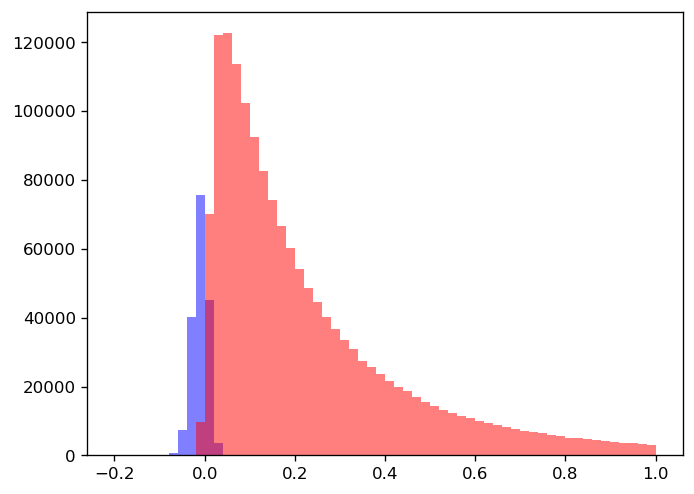

In [18]:
plt.figure(dpi = 120)
missBins = plt.hist(sizeBalr[np.where(classBalr <= 1)[0]], bins = np.linspace(-0.2, 1, 61), color = 'b', alpha = 0.5)
corrBins = plt.hist(sizeBalr[np.where(classBalr >= 2)[0]], bins = np.linspace(-0.2, 1, 61), color = 'r', alpha = 0.5)
plt.show()

In [19]:
sizeGold = np.array([])

for file in goldGalaFiles:
    sizeGold = np.append(sizeGold, fitsio.read(obsGalaDir + file)['SIZE'], axis = 0)

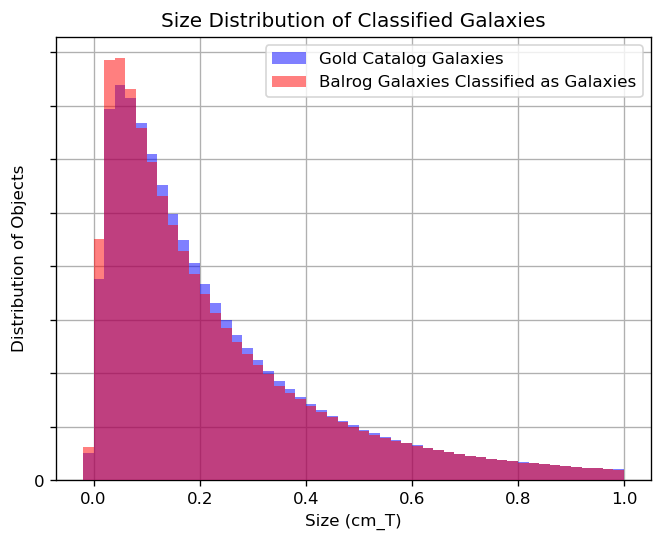

In [20]:
plt.figure(dpi = 120)
goldBins = plt.hist(sizeGold, bins = np.linspace(-0.02, 1, 52), color = 'b', alpha = 0.5, density = True, zorder = 3, label = 'Gold Catalog Galaxies')
balrBins = plt.hist(sizeBalr[np.where(classBalr >= 2)[0]], bins = np.linspace(-0.02, 1, 52), color = 'r', alpha = 0.5, density = True, zorder = 3, label = 'Balrog Galaxies Classified as Galaxies')
plt.legend()
plt.xlabel('Size (cm_T)')
plt.ylabel('Distribution of Objects')
plt.title('Size Distribution of Classified Galaxies')
plt.grid(zorder = 0)
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4], labels = ['0', '', '', '', '', '', '', '', ''])
plt.show()

In [21]:
len(np.where(classBalr >= 2)[0]) / len(classBalr)

0.9050235591090453

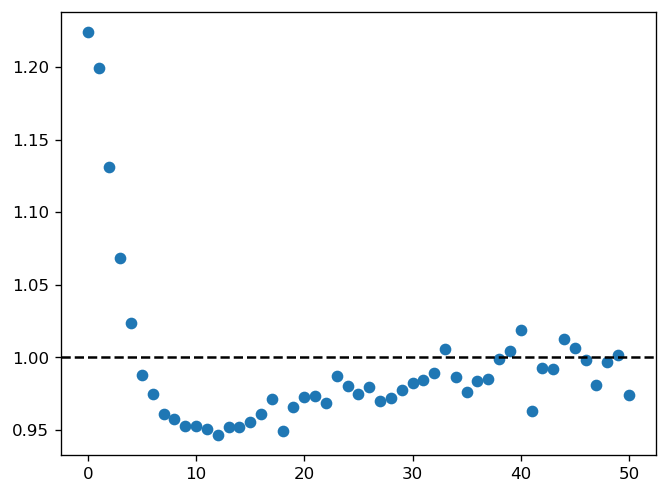

In [22]:
plt.figure(dpi = 120)
plt.scatter(np.arange(51), balrBins[0] / goldBins[0])
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

In [23]:
FOCorrection = goldBins[0] / balrBins[0]

In [24]:
len(np.where(classBalr > 1)[0]) / (np.sum(missBins[0]) + len(np.where(classBalr > 1)[0]))

0.9050235591090453

In [25]:
balrStarData = fitsio.read(starFile)

In [26]:
sizeBalrStar = balrStarData['SIZE']
classBalrStar = balrStarData['CLASS']

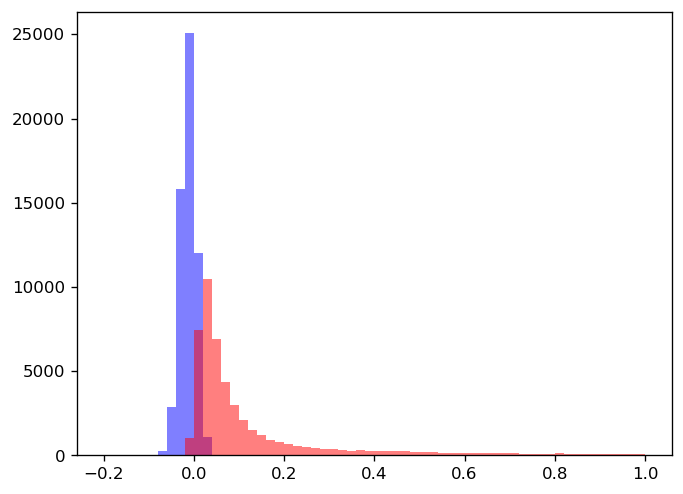

In [27]:
plt.figure(dpi = 120)
plt.hist(sizeBalrStar[np.where(classBalrStar <= 1)[0]], bins = np.linspace(-0.2, 1, 61), color = 'b', alpha = 0.5)
plt.hist(sizeBalrStar[np.where(classBalrStar >= 2)[0]], bins = np.linspace(-0.2, 1, 61), color = 'r', alpha = 0.5)
plt.show()

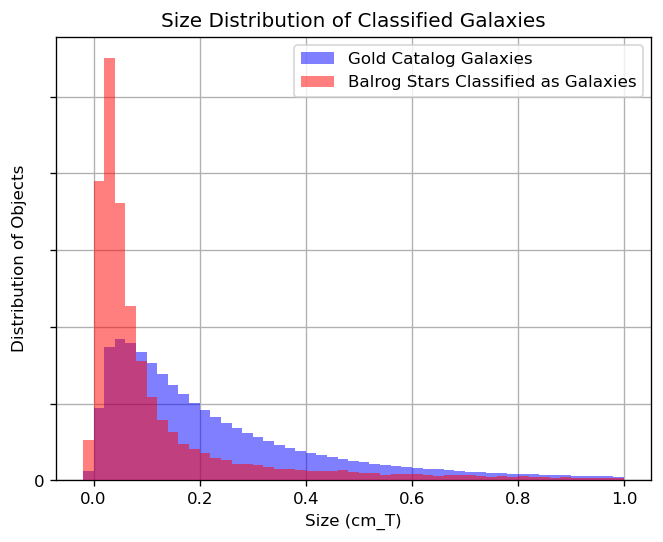

In [28]:
plt.figure(dpi = 120)
plt.hist(sizeGold, bins = np.linspace(-0.02, 1, 52), color = 'b', alpha = 0.5, density = True, zorder = 3, label = 'Gold Catalog Galaxies')
plt.hist(sizeBalrStar[np.where(classBalrStar >= 2)[0]], bins = np.linspace(-0.02, 1, 52), color = 'r', alpha = 0.5, density = True, zorder = 3, label = 'Balrog Stars Classified as Galaxies')
plt.grid(zorder = 0)
plt.legend()
plt.xlabel('Size (cm_T)')
plt.ylabel('Distribution of Objects')
plt.title('Size Distribution of Classified Galaxies')
plt.yticks([0, 2, 4, 6, 8, 10], labels = ['0', '', '', '', '', ''])
plt.show()

In [29]:
len(np.where(classBalrStar <= 1)[0]) / len(classBalrStar)

0.5222008781558727

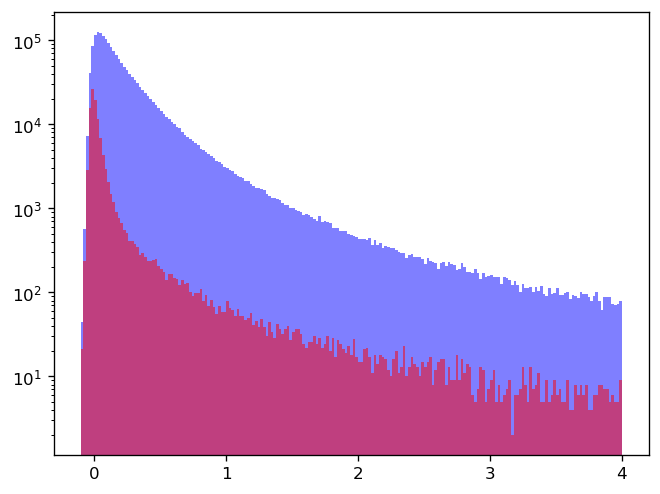

In [30]:
plt.figure(dpi = 120)
plt.hist(sizeBalr, bins = np.linspace(-0.1, 4, 206), color = 'b', alpha = 0.5, density = False)
plt.hist(sizeBalrStar, bins = np.linspace(-0.1, 4, 206), color = 'r', alpha = 0.5, density = False)
plt.yscale('log')
plt.show()